# Plot Backend

Plots the APE, RPE and trajectory against ground truth for the final backend output trajectory.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [17]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/tonirv/Code/ROS/spark_vio_ws/src/spark_vio_ros/output_logs/TESSE/"
gt_data_file = "/home/tonirv/Code/ROS/spark_vio_ws/src/spark_vio_ros/output_logs/TESSE/output_gt_poses.csv"

In [18]:
def get_ape(data, metric):
    """ Gets APE and APE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing APE.
        
        Returns:
            A metrics.APE instance containing the APE for both trajectories according
            to the given metric.
    """
    ape = metrics.APE(metric)
    ape.process_data(data)
    
    return ape


def plot_ape(x_axis, ape, size=(18,10), title=None):
    """ Plots APE error against time for a given metrics.APE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.APE instance with pre-processed data.
            size:   A tuple optionally containing the size of the figure to be plotted.
    """
    if title == None:
        title = "APE w.r.t. " + ape.pose_relation.value
    
    fig = plt.figure(figsize=size)
    plot.error_array(fig, ape.error, x_array=x_axis, statistics=ape.get_all_statistics(), 
                 name="APE", title=title, xlabel="$t$ (s)")
    plt.show()


def get_rpe(data, metric):
    """ Gets RPE and RPE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing RPE.
        
        Returns:
            A metrics.RPE instance containing the RPE for both trajectories according
            to the given metric.
    """
    # normal mode
    delta = 1
    delta_unit = metrics.Unit.frames
    all_pairs = False

    rpe = metrics.RPE(metric, delta, delta_unit, all_pairs)
    rpe.process_data(data)
    return rpe


def plot_rpe(x_axis, rpe, size=(18,10), title=None):
    """ Plots RPE error against time for a given metrics.RPE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.RPE instance with pre-processed data.
            size:   A tuple optionally containing the size of the figure to be plotted.
    """
    if title == None:
        title = "RPE w.r.t. " + rpe.pose_relation.value
    
    fig = plt.figure(figsize=size)
    plot.error_array(fig, rpe.error, x_array=x_axis, statistics=rpe.get_all_statistics(), 
                     name="RPE", title=title, xlabel="$t$ (s)")
    plt.show()


def rename_euroc_gt_df(df):
    """ Renames a DataFrame built from a EuRoC ground-truth data csv file to be easier to read.
        
        Column labels are changed to be more readable and to be identical to the generic pose 
        trajectory format used with other csv files. Note that '#timestamp' will not actually 
        be renamed if it is the index of the DataFrame (which it should be). It will be 
        appropriately renamed if it is the index name.
        This operation is 'inplace': It does not return a new DataFrame but simply changes
        the existing one.
        
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={" p_RS_R_x [m]": "x",
                       " p_RS_R_y [m]": "y",
                       " p_RS_R_z [m]": "z",
                       " q_RS_w []": "qw",
                       " q_RS_x []": "qx",
                       " q_RS_y []": "qy",
                       " q_RS_z []": "qz",
                       " v_RS_R_x [m s^-1]": "vx",
                       " v_RS_R_y [m s^-1]": "vy",
                       " v_RS_R_z [m s^-1]": "vz",
                       " b_w_RS_S_x [rad s^-1]": "bgx",
                       " b_w_RS_S_y [rad s^-1]": "bgy",
                       " b_w_RS_S_z [rad s^-1]": "bgz",
                       " b_a_RS_S_x [m s^-2]": "bax",
                       " b_a_RS_S_y [m s^-2]": "bay",
                       " b_a_RS_S_z [m s^-2]": "baz"}, inplace=True)
    

def rename_pim_df(df):
    """ Renames a DataFrame built from a PIM measurements csv file to be converted to a trajectory.
    
        This is an 'inplace' argument and returns nothing.
    
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={"tx": "x",
                       "ty": "y",
                       "tz": "z"}, inplace=True)

## Backend Trajectory

Associate, align and process the trajectory as determined by the backend. Note that this does not include loop closure factors or other optimizations. This is pure VIO.

In [19]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_posesVIO.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

In [20]:
gt_df = gt_df[~gt_df.index.duplicated()]

rename_euroc_gt_df(gt_df)

In [21]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the backend poses as trajectory.
traj_est_unaligned = pandas_bridge.df_to_trajectory(output_poses_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

traj_ref:  301 poses, 32.703m path length, 77.555s duration
traj_est:  301 poses, 32.777m path length, 77.558s duration


## Absolute-Pose-Error Plotting

Plot absolute-pose-error along the entire trajectory. APE gives a good sense of overall VIO performance across the entire trajectory.

In [22]:
ape_tran = get_ape((traj_ref, traj_est), metrics.PoseRelation.translation_part)

/home/tonirv/Code/spark_vio_evaluation/venv/local/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


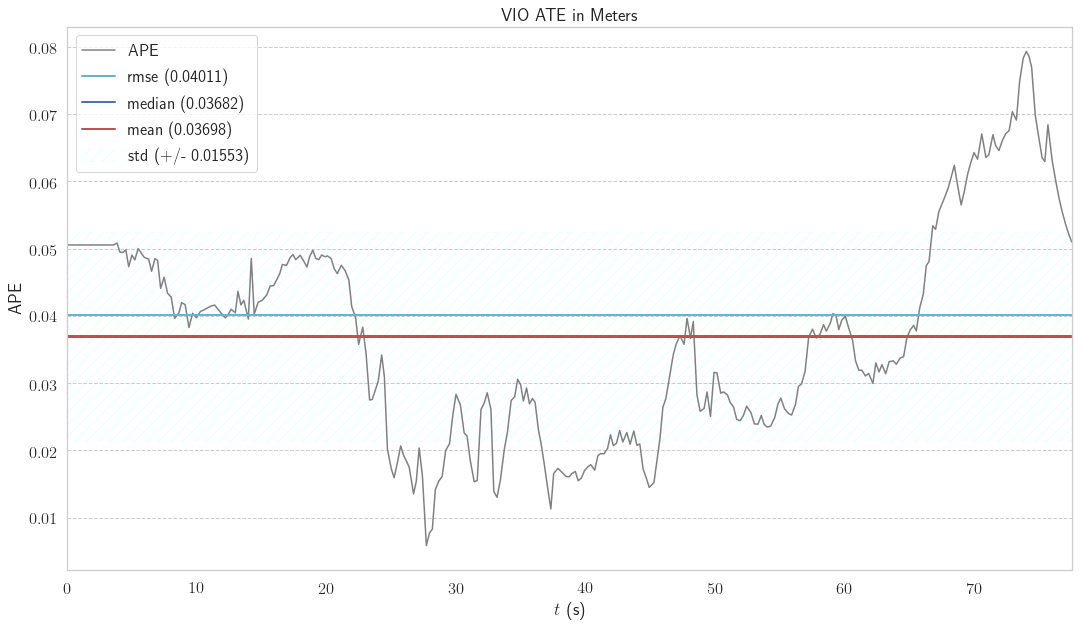

In [23]:
# Plot APE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]

plot_ape(seconds_from_start, ape_tran, title="VIO ATE in Meters")

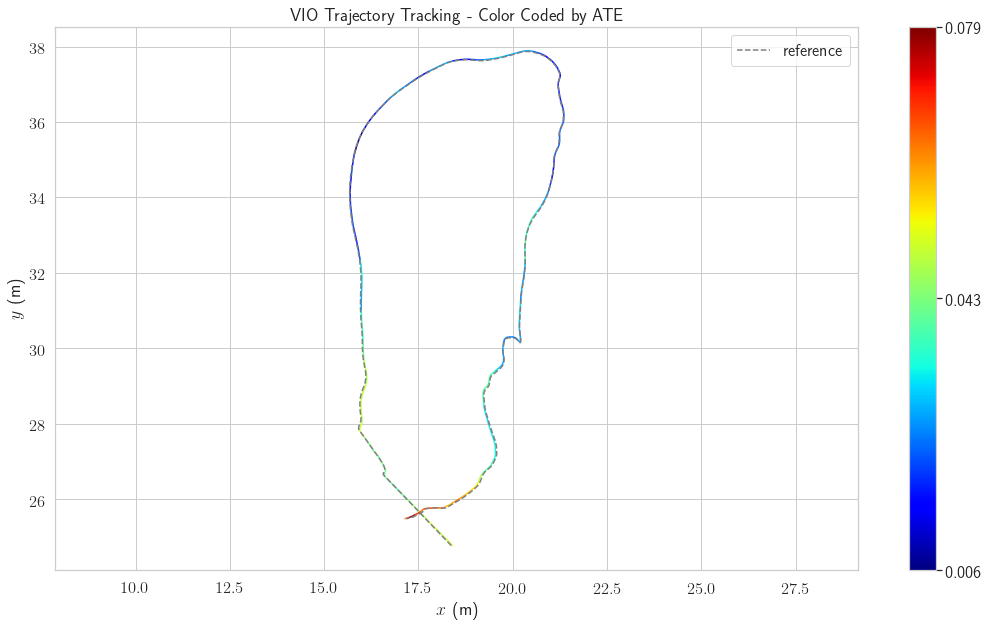

In [24]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est, ape_tran.error, plot_mode,
                   min_map=ape_tran.get_all_statistics()["min"],
                   max_map=ape_tran.get_all_statistics()["max"],
                   title="VIO Trajectory Tracking - Color Coded by ATE")
ax.legend()
plt.show()

## Relative-Pose-Error Plotting

Plot relative-pose-error along the entire trajectory. RPE gives a good sense of overall VIO performance from one frame to the next.

In [25]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

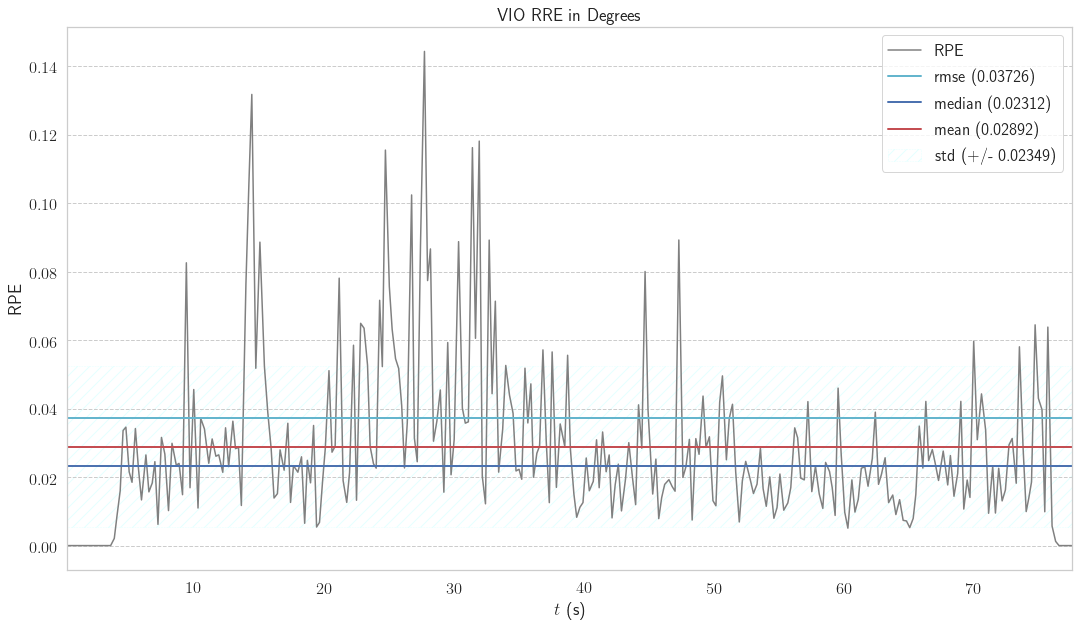

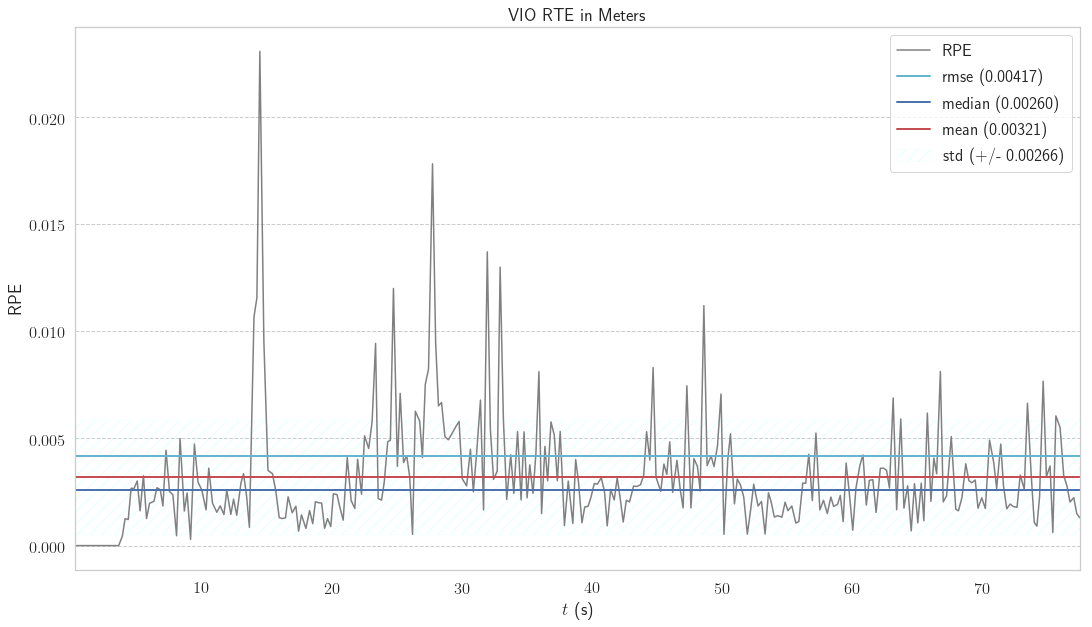

In [26]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot, title="VIO RRE in Degrees")
plot_rpe(seconds_from_start, rpe_tran, title="VIO RTE in Meters")

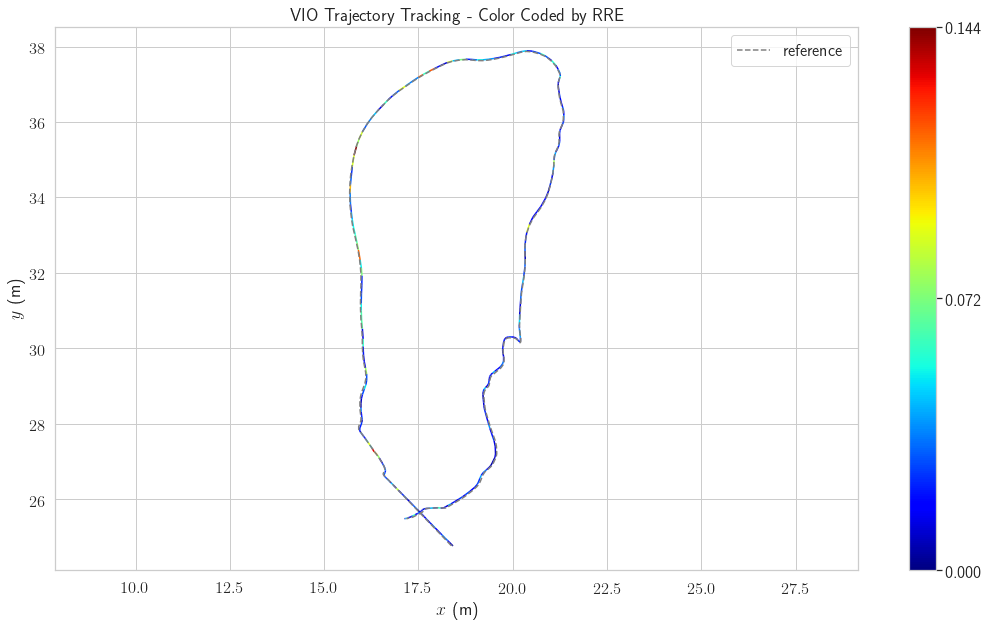

In [27]:
# important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)

# Plot the ground truth and estimated trajectories against each other with RPE overlaid.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"],
                   title="VIO Trajectory Tracking - Color Coded by RRE")
ax.legend()
plt.show()

## Trajectory Plotting

Plot the aligned and associated estimated trajectory against ground truth.

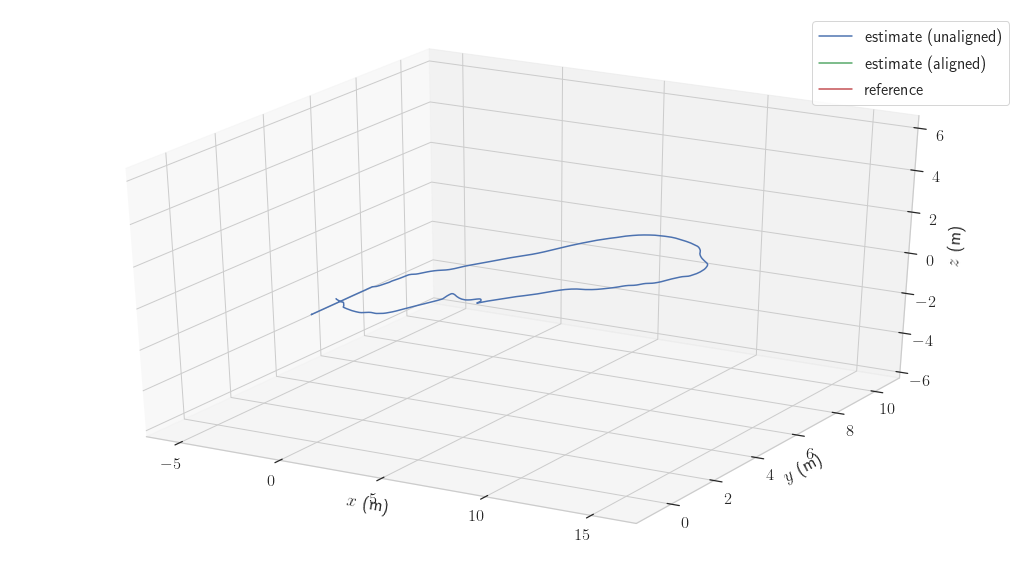

In [28]:
# Plot the trajectories for quick error visualization.

fig = plt.figure(figsize=(18,10))
traj_by_label = {
    "estimate (unaligned)": traj_est_unaligned,
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz, title="PIM Trajectory Tracking in 3D")
plt.show()

## PIM Plotting

Plot preintegrated-imu-measurement estimates of current state over time. This comes in as a trajectory. The plots of error serve to help visualize the error in pim values over time.

Note that these pim values are built off the backend's estimation, not off of ground truth.

In [29]:
pim_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_pim_navstates.csv")
pim_df = pd.read_csv(pim_filename, sep=',', index_col=0)
rename_pim_df(pim_df)

gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]
rename_euroc_gt_df(gt_df)

In [30]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unaligned = pandas_bridge.df_to_trajectory(pim_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

traj_ref:  301 poses, 32.703m path length, 77.555s duration
traj_est:  301 poses, 32.857m path length, 77.558s duration


In [31]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

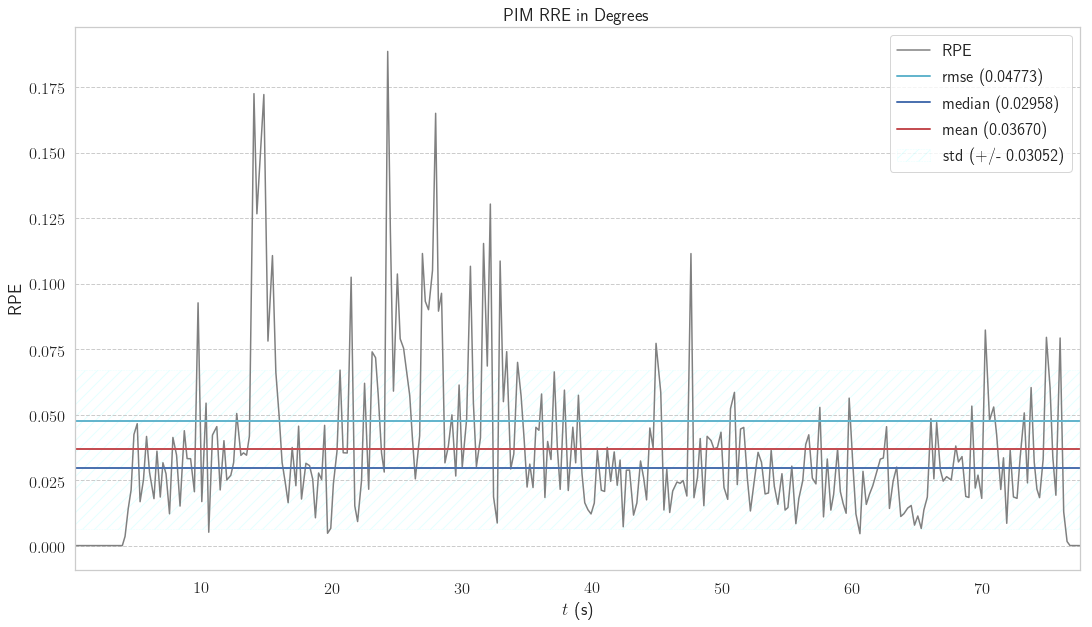

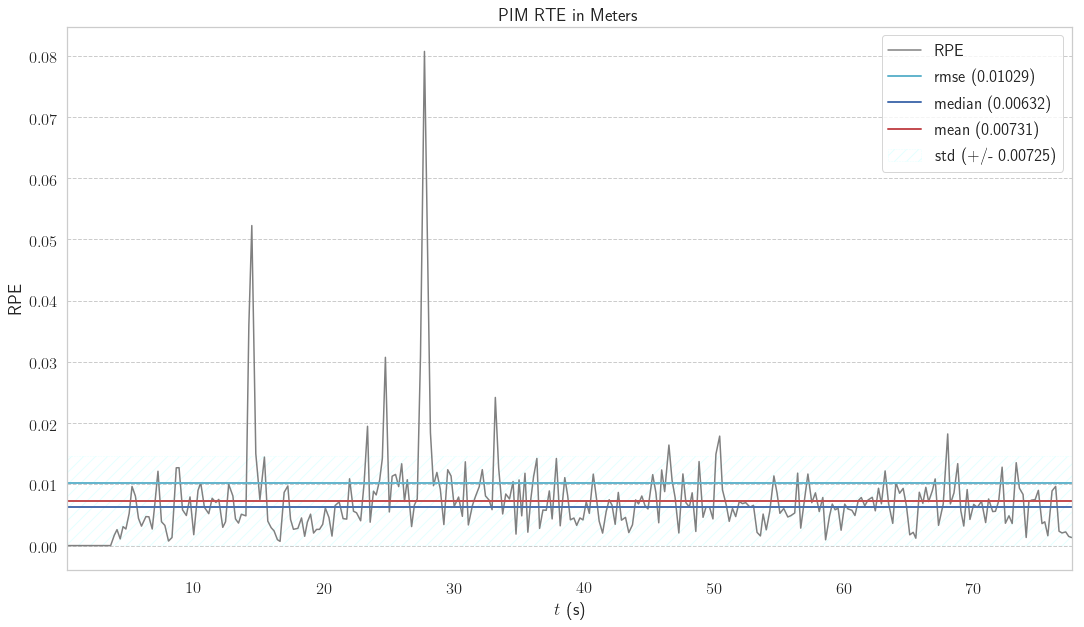

In [32]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot, title="PIM RRE in Degrees")
plot_rpe(seconds_from_start, rpe_tran, title="PIM RTE in Meters")

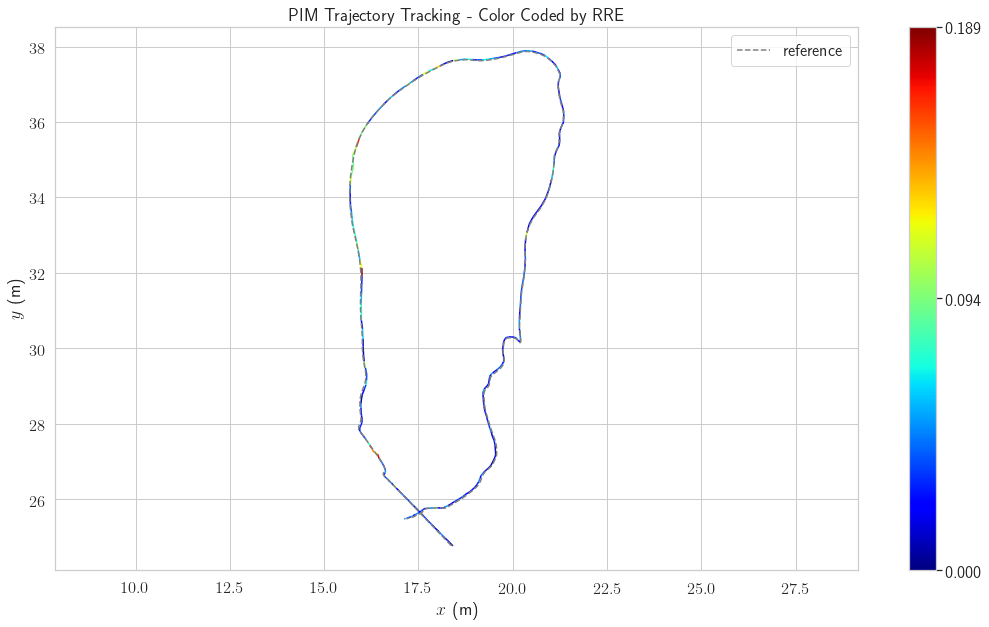

In [33]:
# Important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)

# Plot the ground truth and estimated trajectories against each other with RPE overlaid.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"],
                   title="PIM Trajectory Tracking - Color Coded by RRE")
ax.legend()
plt.show()